# P5 - Identifying Fraud from Enron Emails


##### Question 1(a) - Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question.

The goal of this project is to evaluate internal Enron e-mails of 140+ individuals and financial data related to their earning to try and identify a pattern or correlation between the e-mail and financial data and whether an individual was considered a Person of Interest (POI) in the Enron investigation.

Udacity classified individuals in the financial dataset as a Person of Interest based on the following criteria:

- Individuals who were indicted
- Individuals who reached a settlement or plea deal with the government
- Individuals who testified in exchange for prosecution immunity

### Setting Up the Environment -  
The first step I took was to setup my coding environment by loading the needed python libraries, populate the features_list variable with a complete list of available features and load the data into a data_dict object. I intentionally started with a complete list of available features (excluding the non-numeric values of email_address) so I can use different variations when choosing the best features (see Question 2).

In addition, I created a function called get_kbest_features that accepts a dataframe and an integer number and returns a list of features using SelectKBest and the integer as the value of k.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import tree
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from tester import test_classifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

def get_kbest_features(df, k):
    sel_kbest = SelectKBest(f_regression, k)
    sel_kbest.fit(df, df['poi'])
    features_SelectKBest = df.columns[sel_kbest.get_support()].tolist()
    return features_SelectKBest

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = ['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 
                 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 
                 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 
                 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 
                 'to_messages', 'total_payments', 'total_stock_value']

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Rubric Item: Data Exploration -  
Finding out how many Persons Of Interest, Data Points and Features we have in our dataset.

In [3]:
data_points_count = len(data_dict)
data_features_count = len(data_dict[data_dict.keys()[0]])

poi_count = 0
for value in data_dict.values():
    if value['poi'] == 1:
        poi_count += 1

print "# of POIs: ", poi_count
print "# of Data points: ", data_points_count
print "# of Features: ", data_features_count

# of POIs:  18
# of Data points:  146
# of Features:  21


### Rubric Item: Outlier Investigation -  

##### Question 1(b) - Were there any outliers in the data when you got it, and how did you handle those?
By plotting the available features (see sample plot of Salary and Bonus below) I was able to identify an outlier that existed across all features called "TOTAL". This was clearly a total of all the values of data points and I decided to remove it from the dataset.

TOTAL


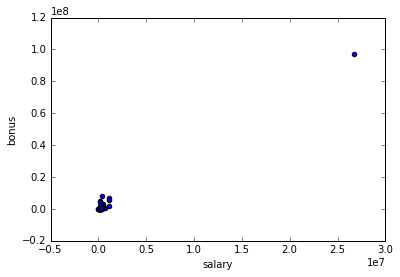

In [4]:
### Task 2: Remove outliers
### Identifying outlier by plotting values.

# testing for outliers visually with Salary and Bonus data
outlier_features = ["salary", "bonus"]
outlier_data = featureFormat(data_dict, outlier_features)

# Plotting
plt.scatter(outlier_data[:,0], outlier_data[:,1])
plt.xlabel("salary")
plt.ylabel("bonus")

# convert to Dataframe to identify outlier record
outlier_df = pd.DataFrame(data_dict)

# show "person" with highest salary/bonus values that is skewing our data
print outlier_df.loc['salary',:].idxmax(axis=1)



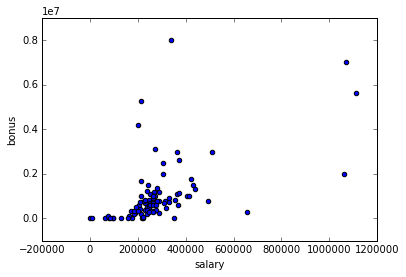

In [5]:
### Found and removed a row for TOTAL that seems to be the outlier 
### across all values as it represents the total line in the report.
data_dict.pop('TOTAL', 0)

# reload outlier_data after TOTAL removal
outlier_data = featureFormat(data_dict, outlier_features)

# Plot again, now showing a more reasonable plot
plt.scatter(outlier_data[:,0], outlier_data[:,1])
plt.xlabel("salary")
plt.ylabel("bonus")

### Rubric Item: Creating New Features -

##### As part of the assignment, you should attempt to engineer your own feature that does not come readymade in the dataset explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.)

I created 4 new features:
- **total_pay:** Sum of each Data Point's Total Stock Value and Total Payments. The reason I created this feature is to check for any correlation between the overall amount of money a person received and their likelihood of being a POI.
- **salary_total_pay_ratio:** This is the portion of a person's salary in their overall compensation they received. I created this feature to evaluate of POIs seem to receive more compensation that is not their base salary that other individuals. I chose to use a ratio so we can get a sense of the proportions regardless of the overall compensation.
- **from_poi_ratio:** This is the ratio of e-mails received from POIs as a portion of all e-mails received by a person. I chose to use a ratio to standardize values across data points regardless of how many e-mails this person received overall. 
- **to_poi_ratio:** This is the ratio of e-mails sent to POIs as a portion of all e-mails sent by a person. I chose to use a ratio to standardize values across data points regardless of how many e-mails this person sent overall.

The reason I chose the last two features is so our testing is aligned with the project overall purpose of using the e-mails data set to find any correlation between a person's likelihood of being a POI and any features we are able to collect from the e-mails data set.

In [8]:
data = featureFormat(data_dict, features_list, sort_keys = True)

### Task 3: Create new feature(s)
df = pd.DataFrame(data, columns = ['poi',
                 'bonus',
                 'deferral_payments',
                 'deferred_income',
                 'director_fees',
                 #'email_address', #excluding non-numeric value
                 'exercised_stock_options',
                 'expenses',
                 'from_messages',
                 'from_poi_to_this_person',
                 'from_this_person_to_poi',
                 'loan_advances',
                 'long_term_incentive',
                 'other',
                 'restricted_stock',
                 'restricted_stock_deferred',
                 'salary',
                 'shared_receipt_with_poi',
                 'to_messages',
                 'total_payments',
                 'total_stock_value'
                ])

df['total_pay'] = df['total_stock_value'] + df['total_payments']
df['salary_total_pay_ratio'] = df['salary'] / df['total_pay']
df['from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']

# replacing all NaN with 0
df = df.replace({np.nan: 0})

### SelectKBest Scores of All Features:
As you can see below, the new 'total_pay' and 'to_poi_ratio' features are in the top 10 SelectKBest scores.

In [9]:
feature_scores_kbest = SelectKBest(f_regression, k='all').fit(df, df['poi'])
feature_scores = sorted(enumerate(feature_scores_kbest.scores_),key=lambda x:x[1], reverse=True)[:1000]
feature_scores_indices = map(list,zip(*feature_scores))[0]
i = 1
for feature_pvalue in feature_scores:
    print '{3}. {2}  :  {1}'.format(feature_pvalue[0], df.columns[feature_pvalue[0]], feature_pvalue[1], i)
    i = i+1

1. 6.39511147087e+17  :  poi
2. 25.0975415287  :  exercised_stock_options
3. 24.4676540475  :  total_stock_value
4. 21.0600017075  :  bonus
5. 18.575703268  :  salary
6. 17.187006077  :  total_pay
7. 16.6417070705  :  to_poi_ratio
8. 11.5955476597  :  deferred_income
9. 10.0724545294  :  long_term_incentive
10. 9.34670079105  :  restricted_stock
11. 8.86672153711  :  total_payments
12. 8.74648553213  :  shared_receipt_with_poi
13. 7.24273039654  :  loan_advances
14. 6.23420114051  :  expenses
15. 5.34494152315  :  from_poi_to_this_person
16. 4.2049708583  :  other
17. 3.21076191697  :  from_poi_ratio
18. 2.42650812724  :  from_this_person_to_poi
19. 2.10765594328  :  director_fees
20. 1.69882434858  :  to_messages
21. 0.21705893034  :  deferral_payments
22. 0.164164498234  :  from_messages
23. 0.0649843117237  :  restricted_stock_deferred
24. 0.00255088867495  :  salary_total_pay_ratio


### Impact of New Features on Performance:

Jumping ahead a bit, it turns out that the best performance I got was using the Gaussian NB CLassifier and the top 8 features from SelectKBest ('poi', 'bonus', 'deferred_income', 'exercised_stock_options', 'salary', 'total_stock_value', 'total_pay', 'to_poi_ratio'). 
        
        Accuracy: 0.86513	Precision: 0.49235	Recall: 0.37000	F1: 0.42250	F2: 0.38935

In comparrison, excluding the two new features I created that were included previously, 'total_pay' and 'to_poi_ratio', returned the following scores:

        Accuracy: 0.85464	Precision: 0.48876	Recall: 0.38050	F1: 0.42789	F2: 0.39814
        
Comparing the two results, it seems that the new features I added didn't have much of an impact on the performance of the GaussianNB Classifier. Accuracy and Precision were a bit better using the two new features, but Recall and F1 scores actually improved without them.

In [12]:
print test_classifier(GaussianNB(), df.to_dict(orient='index'), ['poi', 'bonus', 'deferred_income', 
                                        'exercised_stock_options', 'salary', 
                                        'total_stock_value'])

GaussianNB(priors=None)
	Accuracy: 0.85464	Precision: 0.48876	Recall: 0.38050	F1: 0.42789	F2: 0.39814
	Total predictions: 14000	True positives:  761	False positives:  796	False negatives: 1239	True negatives: 11204

None


### Is KBest really Best?

The test above made me wonder about the impact the two new features have on performance individually so I ran the same validation twice more, each time omitting only one of the two new features. What I found was that removing to_poi_ratio had no impact on the scores and the results were identical with and without this feature.

In [16]:
print test_classifier(GaussianNB(), df.to_dict(orient='index'), ['poi', 'bonus', 'deferred_income', 
                                        'exercised_stock_options', 'salary', 
                                        'total_stock_value', 'total_pay'])

GaussianNB(priors=None)
	Accuracy: 0.86513	Precision: 0.49235	Recall: 0.37000	F1: 0.42250	F2: 0.38935
	Total predictions: 15000	True positives:  740	False positives:  763	False negatives: 1260	True negatives: 12237

None


Interestingly enough, removing total_pay had fairly significant impact. The scores of Precision, Recall, F1 and F2 have all gone up. In fact, Accuracy was the only score that decreased which made me wonder about my process of feature selection. Having said that, I did notice that the total predictions made with our k=8 features was 15000, yet the validation I ran using the same feature but without total_pay made only 14000 total predictions. An increase of 7.1% in the number of predictions seems significant to me, so after considering the difference in the number of total predictions between the two tests I decided to go forward with the original k=8 feature list.

In [17]:
print test_classifier(GaussianNB(), df.to_dict(orient='index'), ['poi', 'bonus', 'deferred_income', 
                                        'exercised_stock_options', 'salary', 
                                        'total_stock_value', 'to_poi_ratio'])

GaussianNB(priors=None)
	Accuracy: 0.86050	Precision: 0.51572	Recall: 0.38550	F1: 0.44120	F2: 0.40600
	Total predictions: 14000	True positives:  771	False positives:  724	False negatives: 1229	True negatives: 11276

None


### Rubric Item: Feature Scaling -

Feature scaling was not performed because none of the Classifiers I chose to use do not require it. Firstly, the GaussianNB Classifier performs feature scaling as part of its normal behavior. In addition, the DecisionTree Classifier also doesn't require feature scaling because its algorithm doesn't evaluate Euclidean distance. The third Classifier I chose, ADA Boost, also doesn't require any feature scaling because it uses the DecisionTree classifier by default.

### Rubric Item: Feature Selection -

Once the new features have been created, I needed to standardize all the **NaN** values and change them to 0 so our dataset is consistent since our original dataset went through a similar process using the FeatureFormat function. In addition, to get a sense of which of the features have the most amount of data in our dataset, I reviewed a list of each feature and their counts. 

In [10]:
# counting datapoints per feature
df.replace({0: np.nan}).count()

poi                           18
bonus                         81
deferral_payments             38
deferred_income               48
director_fees                 16
exercised_stock_options      101
expenses                      94
from_messages                 86
from_poi_to_this_person       74
from_this_person_to_poi       66
loan_advances                  3
long_term_incentive           65
other                         92
restricted_stock             109
restricted_stock_deferred     17
salary                        94
shared_receipt_with_poi       86
to_messages                   86
total_payments               124
total_stock_value            125
total_pay                    142
salary_total_pay_ratio        94
from_poi_ratio                74
to_poi_ratio                  66
dtype: int64

In [11]:
### Store to my_dataset for easy export below.
my_dataset = df.to_dict(orient='index')

### Originally started with 146 data points. 
### 1 data point was removed when we identified the outlier, 
### the second row was removed in the conversion to/from the DataFrame
### due to all of it's values being zero.

print len(my_dataset)

144


##### Question 2: What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not?  In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.

Using the get_kbest_features function I created, I tested each one of the three Classifiers I decided to use (Gaussian NB, Decision Tree, and ADA Boost) using the test_classifier function provided in tester.py using the feature selection from SelectKBest where k was every integer between 2 and the total count of features.

The reason I tested multiple variations of features against each one of the classifiers I chose was to make sure that I'm using the best list of features for each classifier instead of choosing a single list of SelectKBest features and using it with all the classifiers. As a result, I found that when evaluating for the highest possible F1 value, Gaussian NB performed the best using a list of 8 features, but both the Decision Tree and ADA Boost classifiers performed better with only a list of 4 features.

I focused on the F1 score was because it considers both the precision and recall scores and not just accuracy. I felt that this was a better indicator because the accuracy score can be biased due to our small data set. This is evident when reviewing the results of the Gaussian NB below that shows the highest accuracy achieved was using only the 'poi' and 'exercised_stock_options' features.

### Rubric Item: Picking an Algorithm -

##### 3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?

In [8]:
### Task 4: Try a variety of classifiers

### testing results of GaussianNB against all feature combinations using SelectKBest
for i in range(2, (len(data_dict[data_dict.keys()[0]]))):
    print '\nSelectKBest k=' + str(i)
    print 'used features: ' + str(get_kbest_features(df, i))
    clf = GaussianNB()
    print test_classifier(clf, my_dataset, get_kbest_features(df, i))



SelectKBest k=2
used features: ['poi', 'exercised_stock_options']
GaussianNB(priors=None)
	Accuracy: 0.90409	Precision: 0.46055	Recall: 0.32100	F1: 0.37831	F2: 0.34171
	Total predictions: 11000	True positives:  321	False positives:  376	False negatives:  679	True negatives: 9624

None

SelectKBest k=3
used features: ['poi', 'exercised_stock_options', 'total_stock_value']
GaussianNB(priors=None)
	Accuracy: 0.84069	Precision: 0.46889	Recall: 0.26750	F1: 0.34066	F2: 0.29264
	Total predictions: 13000	True positives:  535	False positives:  606	False negatives: 1465	True negatives: 10394

None

SelectKBest k=4
used features: ['poi', 'bonus', 'exercised_stock_options', 'total_stock_value']
GaussianNB(priors=None)
	Accuracy: 0.84300	Precision: 0.48581	Recall: 0.35100	F1: 0.40755	F2: 0.37163
	Total predictions: 13000	True positives:  702	False positives:  743	False negatives: 1298	True negatives: 10257

None

SelectKBest k=5
used features: ['poi', 'bonus', 'exercised_stock_options', 'salary', 

### Best F1 Results of GaussianNB Using Default Parameters

        SelectKBest k=8
        used features: ['poi', 'bonus', 'deferred_income', 'exercised_stock_options', 'salary', 'total_stock_value', 'total_pay', 'to_poi_ratio']
        GaussianNB(priors=None)

        Accuracy: 0.86513
        Precision: 0.49235
        Recall: 0.37000
        F1: 0.42250
        F2: 0.38935


        Total predictions: 15000
        True positives:  740
        False positives:  763
        False negatives: 1260
        True negatives: 12237
   

In [9]:

### testing results of DecisionTreeClassifier against all feature combinations using SelectKBest
for i in range(2, (len(data_dict[data_dict.keys()[0]]))):
    print '\nSelectKBest k=' + str(i)
    print 'used features: ' + str(get_kbest_features(df, i))
    clf = tree.DecisionTreeClassifier()
    print test_classifier(clf, my_dataset, get_kbest_features(df, i))
    


SelectKBest k=2
used features: ['poi', 'exercised_stock_options']
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86273	Precision: 0.27434	Recall: 0.31000	F1: 0.29108	F2: 0.30214
	Total predictions: 11000	True positives:  310	False positives:  820	False negatives:  690	True negatives: 9180

None

SelectKBest k=3
used features: ['poi', 'exercised_stock_options', 'total_stock_value']
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.76677	Precis

### Best F1 results of DecisionTreeClasifier Using Default Parameters

        SelectKBest k=4
        used features: ['poi', 'bonus', 'exercised_stock_options', 'total_stock_value']
        DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                    max_features=None, max_leaf_nodes=None,
                    min_impurity_split=1e-07, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    presort=False, random_state=None, splitter='best')

        Accuracy: 0.80238
        Precision: 0.36485
        Recall: 0.38400
        F1: 0.37418
        F2: 0.38001

        Total predictions: 13000
        True positives:  768
        False positives: 1337
        False negatives: 1232
        True negatives: 9663

In [10]:

### testing results of AdaBoostClassifier against all feature combinations using SelectKBest
for i in range(2, (len(data_dict[data_dict.keys()[0]]))):
    print '\nSelectKBest k=' + str(i)
    print 'used features: ' + str(get_kbest_features(df, i))
    clf = AdaBoostClassifier()
    print test_classifier(clf, my_dataset, get_kbest_features(df, i))



SelectKBest k=2
used features: ['poi', 'exercised_stock_options']
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.85700	Precision: 0.25985	Recall: 0.31000	F1: 0.28272	F2: 0.29848
	Total predictions: 11000	True positives:  310	False positives:  883	False negatives:  690	True negatives: 9117

None

SelectKBest k=3
used features: ['poi', 'exercised_stock_options', 'total_stock_value']
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.81915	Precision: 0.37419	Recall: 0.26100	F1: 0.30751	F2: 0.27781
	Total predictions: 13000	True positives:  522	False positives:  873	False negatives: 1478	True negatives: 10127

None

SelectKBest k=4
used features: ['poi', 'bonus', 'exercised_stock_options', 'total_stock_value']
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=

### Best F1 results of AdaBoostClassifier Using Default Parameters

        SelectKBest k=4
        used features: ['poi', 'bonus', 'exercised_stock_options', 'total_stock_value']
        AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)

        Accuracy: 0.80515
        Precision: 0.34461
        Recall: 0.29550
        F1: 0.31817
        F2: 0.30417

        Total predictions: 13000
        True positives:  591
        False positives: 1124
        False negatives: 1409
        True negatives: 9876

### Rubric Item: Tuning the Algorithm -

##### Question 4 - What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well? How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).

Tuning the parameters of an algorithm is the process of optimizing the parameters that impact the algorithm's behavior to achieve the best performance. The most basic way of tuning an algorithm is by trying multiple variations of the values the algorithm accepts and reviewing the results (For example, varying the value of k when using the SelectKBest algorhythm controlled the number of returned features). As you saw above, the number of returned features has a significant impact on our Classifier testing and we achieved better performance when we used different k values when testing the various classifiers. Not tuning the algorithms properly can have a significant and cascading effect on our results and the performance we can achieve from our classifiers. For example, choosing to use k = 2 in our feature selection because it had the highest accuracy rate when using the GassiuanNB classifier wouldn't have been the correct choice since in this instance accuracy is less important than the recall, precision and/or F1 values. 

My initial testing showed that I was able to get the best F1 score using the Gaussian NB with a list of 8 features generated by SelectKBest. Unfortunately, the Gaussian NB classifier has no tunable parameters so I performed my tuning on the Decision Tree and ADA Boost Classifiers instead. I tuned the parameters of those two classifiers by using GridSearchCV with an array that contained a list of possibilities for each parameter. GridSearchCV than ran through each possible combination and recommended the best parameter values. The GridSearchCV algorithm itself can also be tuned by specifying the kind of scoring and number of folds it should use when testing.

In [11]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script.

data = featureFormat(my_dataset, get_kbest_features(df, 4), sort_keys = True)
labels, features = targetFeatureSplit(data)

#from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [18]:
parameters = {'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 8, 10, 20],
               'max_depth': [None, 2, 5, 8, 10],
               'min_samples_leaf': [1, 2, 5, 8, 10],
               'max_leaf_nodes': [None, 2, 5, 10, 20]}
svr = tree.DecisionTreeClassifier()
clf = GridSearchCV(svr, parameters, scoring='f1', verbose=1, error_score='raise', n_jobs=5, cv = 10)
clf.fit(features, labels)
print clf.best_params_

Fitting 10 folds for each of 1250 candidates, totalling 12500 fits


[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 1210 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 3210 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 6010 tasks      | elapsed:   21.5s
[Parallel(n_jobs=5)]: Done 9610 tasks      | elapsed:   33.8s


{'min_samples_split': 2, 'max_leaf_nodes': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}


[Parallel(n_jobs=5)]: Done 12500 out of 12500 | elapsed:   43.6s finished


In [22]:
best_f1_dtc = tree.DecisionTreeClassifier(min_samples_split=2, 
                                       max_leaf_nodes=None, 
                                       criterion="entropy", 
                                       max_depth=10, 
                                       min_samples_leaf=1)
print "Decision Tree Classifier Tuned to Best F1 score"
print test_classifier(best_f1_dtc, my_dataset, get_kbest_features(df, 4))

Decision Tree Classifier Tuned to Best F1 score
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.79900	Precision: 0.35882	Recall: 0.38950	F1: 0.37353	F2: 0.38295
	Total predictions: 13000	True positives:  779	False positives: 1392	False negatives: 1221	True negatives: 9608

None


In [23]:
default_dtc = tree.DecisionTreeClassifier()
print "Decision Tree Classifier Untuned"
print test_classifier(default_dtc, my_dataset, get_kbest_features(df, 4))

Decision Tree Classifier Untuned
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.80138	Precision: 0.36364	Recall: 0.38800	F1: 0.37542	F2: 0.38287
	Total predictions: 13000	True positives:  776	False positives: 1358	False negatives: 1224	True negatives: 9642

None


In [36]:
parameters = {'n_estimators': [30, 40, 50],
               'algorithm': ['SAMME', 'SAMME.R'],
               'learning_rate': [.5, .8, 1, 1.2]}
svr = AdaBoostClassifier()
clf = GridSearchCV(svr, parameters, scoring='f1', verbose=1, error_score='raise', n_jobs=5, cv = 5)
clf.fit(features, labels)

print clf.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.9s


{'n_estimators': 40, 'learning_rate': 1.2, 'algorithm': 'SAMME'}


[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed:    4.7s finished


In [37]:
best_f1_ada = AdaBoostClassifier(n_estimators=40,
                                     learning_rate=1.2,
                                     algorithm='SAMME.R')
print "ADA Boost Classifier Tuned to Best F1 score"
print test_classifier(best_f1_ada, my_dataset, get_kbest_features(df, 4))

ADA Boost Classifier Tuned to Best F1 score
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.2, n_estimators=40, random_state=None)
	Accuracy: 0.81138	Precision: 0.36595	Recall: 0.30850	F1: 0.33478	F2: 0.31850
	Total predictions: 13000	True positives:  617	False positives: 1069	False negatives: 1383	True negatives: 9931

None


In [38]:
default_ada = AdaBoostClassifier()
print "ADA Boost Classifier Untuned"
print test_classifier(default_ada, my_dataset, get_kbest_features(df, 4))

ADA Boost Classifier Untuned
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
	Accuracy: 0.80538	Precision: 0.34593	Recall: 0.29750	F1: 0.31989	F2: 0.30607
	Total predictions: 13000	True positives:  595	False positives: 1125	False negatives: 1405	True negatives: 9875

None


### Rubric Item(s): Validation Strategy / Usage of Evaluation Metrics -

##### Question 5: What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?
One way to validate an algorithm is to divide the entire dataset into a learning dataset and a testing dataset. The learning dataset is used when training/fitting the classifiers. We then take the already fitted/trained classifier and use the testing dataset to evaluate the performance of our algorithm. A classic mistake that can be made here is using the same dataset to both train/fit and test. Since the data used for fitting includes the same values as the data used for testing, the data points presented to the algorithm during testing are not new and we are basically evaluating how the algorithm does against data it is familiar with, which doesn't tell us anything about how the algorithm would perform against unknown data. I performed my validation by excluding 30% of the dataset from the training set and used only the remaining 70% when training/fitting. I then used the excluded 30% to test the fitted classifier so I can evaluate how the algorithm performs against a previously unseen dataset.


##### Question 6: Give at least 2 evaluation metrics and your average performance for each of them. Explain an interpretation of your metrics that says something human understandable about your algorithm’s performance. 

As I mentioned previously, my initial testing showed that I was able to get the best F1 score using the Gaussian NB using a list of 8 features generated by SelectKBest (poi, bonus, deferred_income, exercised_stock_options, salary, total_stock_value, total_pay, to_poi_ratio), but since the Gaussian NB classifer has no tunable parameters, I performed my tuning on the Decision Tree and ADA Boost Classifiers instead. 

One of the goals of this project was to be able to achieve precision and recall scores better than 0.3. Precision and Recall are defined as follows:

- **Precision:** In our case, precision is defined as the probability that the prediction made by the algorithm is correct. In other words, if our algorithm indicates that a person is likely to be a POI based on the features it evaluates, the Precision is the fraction of individuals that should truly be classified as POIs from all the individuals identified as potential POIs using our algorithm.
- **Recall:** Also known as sensitivity, is a measure of how many potential POIs our algorithm missed. In other words, the fraction of individuals that should have been classified as POIs based on the features evaluated by our algorithm that were evalauted as non-POIs.

I was able to achieve precision and recall scores better than 0.3 in all cases, although the results of these two classifiers were lower than what I was able to achieve using the Gaussian NB classifier.

The best scores I achieved for each classifier were as follows:
    
##### Gaussian NB Classifier - Default:
        SelectKBest k=8
        Features: poi, bonus, deferred_income, exercised_stock_options, salary, total_stock_value, total_pay, to_poi_ratio
        
        Accuracy: 0.86513	Precision: 0.49235	Recall: 0.37000	
        F1: 0.42250	F2: 0.38935
        
        Total predictions: 15000	
        True positives:  740	False positives:  763	False negatives: 1260	True negatives: 12237
        
##### Decision Tree Classifier - Default:
        SelectKBest k=4
        Features: poi, bonus, exercised_stock_options, total_stock_value

        Accuracy: 0.80138	Precision: 0.36364	Recall: 0.38800
        F1: 0.37542	F2: 0.38287
        
        Total predictions: 13000
        True positives:  776	False positives: 1358	False negatives: 1224	True negatives: 9642

##### ADA Booster Classifier - Tuned: algorithm='SAMME.R'; learning_rate=1.2; n_estimators=40
        SelectKBest k=4
        Features: poi, bonus, exercised_stock_options, total_stock_value

        Accuracy: 0.81138	Precision: 0.36595	Recall: 0.30850
        F1: 0.33478	F2: 0.31850
        
        Total predictions: 13000
        True positives:  617	False positives: 1069	False negatives: 1383	True negatives: 9931


Overall, I feel that the Gaussian NB classifier performed best not only because of the higher scores in accuracy, precision, recall and F1/F2, but also because the Total prediction the tester function ran was 15K instead of 13K because of the larger number of features. In addition, the Gaussian NB classifier was the only classifier that performed better with a list of features that included any reference to information derived from e-mail data. The other two classifiers (Decision Tree and ADA Boost) performed best with only 4 features, none of which referenced any e-mail related information. These Classifiers performed best when the features they evaluated were not related to the e-mail data, which makes their result not very relevant to this project.

That being said, using the Gaussian NB classifier introduces a fairly significant bias because of its "Naive" tendency to assume there is no relation between the features, which in our case is incorrect. Several of our features are a summation of other features (for example, the feature **total_pay** is a sum of **bonus, deferred_income, exercised_stock_options, salary, total_stock_value,** and several other features and clearly has a strong relationship to them).


In [14]:
features_list = get_kbest_features(df, 8)

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
train_test_split(features, labels, test_size=0.3, random_state=42)

clf = GaussianNB()
clf.fit(features_train, labels_train)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

### Rubric Item: poi_id.py

        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd
        import random
        import sys
        import pickle
        sys.path.append("../tools/")

        from feature_format import featureFormat, targetFeatureSplit
        from tester import dump_classifier_and_data

        #from sklearn.feature_selection import SelectPercentile, f_classif
        from sklearn.feature_selection import SelectKBest, f_regression
        from sklearn.cross_validation import train_test_split
        from sklearn.metrics import accuracy_score, precision_score, recall_score
        from sklearn import tree
        from sklearn.grid_search import GridSearchCV
        from sklearn.ensemble import AdaBoostClassifier
        from tester import test_classifier
        from sklearn.naive_bayes import GaussianNB
        from sklearn import svm

        def get_kbest_features(df, k):
            sel_kbest = SelectKBest(f_regression, k)
            sel_kbest.fit(df, df['poi'])
            features_SelectKBest = df.columns[sel_kbest.get_support()].tolist()
            return features_SelectKBest

        ### Task 1: Select what features you'll use.
        ### features_list is a list of strings, each of which is a feature name.
        ### The first feature must be "poi".
        ### features_list = ['poi','salary'] # You will need to use more features

        features_list = ['poi',
                         'bonus',
                         'deferral_payments',
                         'deferred_income',
                         'director_fees',
                         # 'email_address', #excluding non-numeric value
                         'exercised_stock_options',
                         'expenses',
                         'from_messages',
                         'from_poi_to_this_person',
                         'from_this_person_to_poi',
                         'loan_advances',
                         'long_term_incentive',
                         'other',
                         'restricted_stock',
                         'restricted_stock_deferred',
                         'salary',
                         'shared_receipt_with_poi',
                         'to_messages',
                         'total_payments',
                         'total_stock_value'
                        ]

        ### Load the dictionary containing the dataset
        with open("final_project_dataset.pkl", "r") as data_file:
            data_dict = pickle.load(data_file)


        ### Task 2: Remove outliers
        data_dict.pop('TOTAL', 0)


        ### Task 3: Create new feature(s)
        ### Store to my_dataset for easy export below.

        data = featureFormat(data_dict, features_list, sort_keys = True)
        df = pd.DataFrame(data, columns = ['poi',
                         'bonus',
                         'deferral_payments',
                         'deferred_income',
                         'director_fees',
                         #'email_address', #excluding non-numeric value
                         'exercised_stock_options',
                         'expenses',
                         'from_messages',
                         'from_poi_to_this_person',
                         'from_this_person_to_poi',
                         'loan_advances',
                         'long_term_incentive',
                         'other',
                         'restricted_stock',
                         'restricted_stock_deferred',
                         'salary',
                         'shared_receipt_with_poi',
                         'to_messages',
                         'total_payments',
                         'total_stock_value'
                        ])

        df['total_pay'] = df['total_stock_value'] + df['total_payments']
        df['salary_total_pay_ratio'] = df['salary'] / df['total_pay']

        df['from_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
        df['to_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']

        # replacing all NaN with 0
        df = df.replace({np.nan: 0})

        ### Store to my_dataset for easy export below.
        my_dataset = df.to_dict(orient='index')


        ### Extract features and labels from dataset for local testing

        features_list = get_kbest_features(df, 8)

        data = featureFormat(my_dataset, features_list, sort_keys = True)
        labels, features = targetFeatureSplit(data)


        ### Task 4: Try a varity of classifiers
        ### Please name your classifier clf for easy export below.
        ### Note that if you want to do PCA or other multi-stage operations,
        ### you'll need to use Pipelines. For more info:
        ### http://scikit-learn.org/stable/modules/pipeline.html

        # Provided to give you a starting point. Try a variety of classifiers.
        # from sklearn.naive_bayes import GaussianNB
        clf = GaussianNB()

        ### Task 5: Tune your classifier to achieve better than .3 precision and recall 
        ### using our testing script. Check the tester.py script in the final project
        ### folder for details on the evaluation method, especially the test_classifier
        ### function. Because of the small size of the dataset, the script uses
        ### stratified shuffle split cross validation. For more info: 
        ### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

        # Example starting point. Try investigating other evaluation techniques!
        # from sklearn.cross_validation import train_test_split
        features_train, features_test, labels_train, labels_test = \
            train_test_split(features, labels, test_size=0.3, random_state=42)

        clf.fit(features_train, labels_train)

        ### Task 6: Dump your classifier, dataset, and features_list so anyone can
        ### check your results. You do not need to change anything below, but make sure
        ### that the version of poi_id.py that you submit can be run on its own and
        ### generates the necessary .pkl files for validating your results.

        dump_classifier_and_data(clf, my_dataset, features_list)